In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at

# Section 1 - Load in Functions

In [264]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [265]:
## Load in data

Generated_data = pd.read_csv(save_dir + "1year_generated_data.csv")

In [266]:
## Assign arrays for indexing

F0_CSF_array_full = np.array(Generated_data['Generated FF'])
Time_CSF_array_full = np.array(Generated_data['Time'])

In [267]:
## Define function to fit line 

def fit_line(Array_of_interest1,Array_of_interest2,index,numberhrs):
    
    m,b = np.polyfit(Array_of_interest1[index:index+numberhrs],-1*Array_of_interest2[index:index +numberhrs], 1)
    
    return m,b

In [268]:
## Define function to steer CSF 

def CSF_Correction(loop_range,number_hours):

    i = 0
    F0_CSF_array_full1= np.array(Generated_data['Generated FF'])
    steps = []                                   # store steps to steer GPS data later

    for i in loop_range:

        m,b = fit_line(Time_CSF_array_full,-1*F0_CSF_array_full1,i,number_hours)     ## fit to section of data 
        step_f = m*(Time_CSF_array_full[i+(number_hours-1)]) + b                ## calculate step using fit (removes outliers)

        steps.append(step_f)


        F0_CSF_array_full1[i:] -= step_f             # add step to all frequencies from this index on
        
        
    return F0_CSF_array_full1,steps

In [269]:
## Define function to do threshold steer

# def Threshold_steer(threshold_f):

#     f0_array_threshold_full1 = np.array(Generated_data['Generated FF'])

#     for i in Range:

#         m1,b1 = fit_line(Generated_data['Time'],-1*f0_array_threshold_full1,i,6)     ## fit to section of data 
#         step_f0_th = m1*(Generated_data['Time'][i+(5)]) + b1   


#         if f0_array_threshold_full1[i] < threshold_f:
#             f0_array_threshold_full1[i:] -= step_f0_th

#         else :
#             f0_array_threshold_full1[i:] = f0_array_threshold_full1[i:]
            
    
#     return f0_array_threshold_full1

## Define function to do threshold steer

def Threshold_steer(threshold_f,index_range,hours):

    f0_array_threshold_full1 = np.array(Generated_data['Generated FF'])

    for i in index_range:

        m1,b1 = fit_line(Generated_data['Time'],-1*f0_array_threshold_full1,i,int(hours))     ## fit to section of data 
        step_f0_th = m1*(Generated_data['Time'][i+(int(hours)-1)]) + b1   


        if abs(f0_array_threshold_full1[i]) > threshold_f:
            f0_array_threshold_full1[i:] -= step_f0_th

        else :
            f0_array_threshold_full1[i:] = f0_array_threshold_full1[i:]
            
    
    return f0_array_threshold_full1

In [270]:
## Define function to perform smooth steer

def smooth_steer_CSF(range_loop,no_hours,day_conversion,original_array):
    
    offset_array_CSF1 = original_array
    

    for i in range_loop:


        m_d,b_f = fit_line(Time_CSF_array_full,-1*offset_array_CSF1,i,no_hours)     ## fit to section of data 


        def f_off(slope,index) :
            return slope*(Time_CSF_array_full[index]) + b_f                                    ## function to find f_off

        f_0 = f_off(m_d,(i+(no_hours-1)))


        m = - (f_0+(day_conversion)*m_d)/day_conversion                                                  ## find m 


        def shift(t):                                                        ## define lin function to be added to original data
            return m*t

        set_interest1 = Time_CSF_array_full[i+no_hours:]
        line3 = np.array(shift(set_interest1-set_interest1[0]))

        index = len(Time_CSF_array_full) - len(set_interest1)

        offset_array_CSF1[index:] += line3
        
    return(offset_array_CSF1)

In [271]:
## Define function to plot steered data against raw data

def plot_steer(step_hrs,shifted_array):
    
    plt.figure(figsize=(15,10))
    
    plot1 = plt.scatter(Time_CSF_array_full,Generated_data['Generated FF'],label='Raw')
    plot2 = plt.scatter(Time_CSF_array_full,shifted_array,label='Shifted after '+ str(step_hrs) +' hrs')
    
    plt.title('Plot of Fractional Frequency corrected by step every ' +  str(step_hrs) + ' hrs - CSF',fontsize=25)
    plt.xlabel('MJD (days)',fontsize=20)
    plt.ylabel('Fractional Frequency',fontsize=20)

    plt.legend(fontsize=20)
    
    return(plot1,plot2)

In [272]:
## Define function to calculate Allan Deviation and plot

def Allan_Dev(y,rate,t,hrs) : 
    
    (t, ad1, ade, adn) = at.oadev(y, rate, data_type="freq",taus=t)
    
    return plt.loglog(t,ad1,'x',label= str(hrs) +' hrs')

# Section 2 - Jump Steer

(<matplotlib.collections.PathCollection at 0x7fbe0e3f9a00>,
 <matplotlib.collections.PathCollection at 0x7fbe0e3f9e20>)

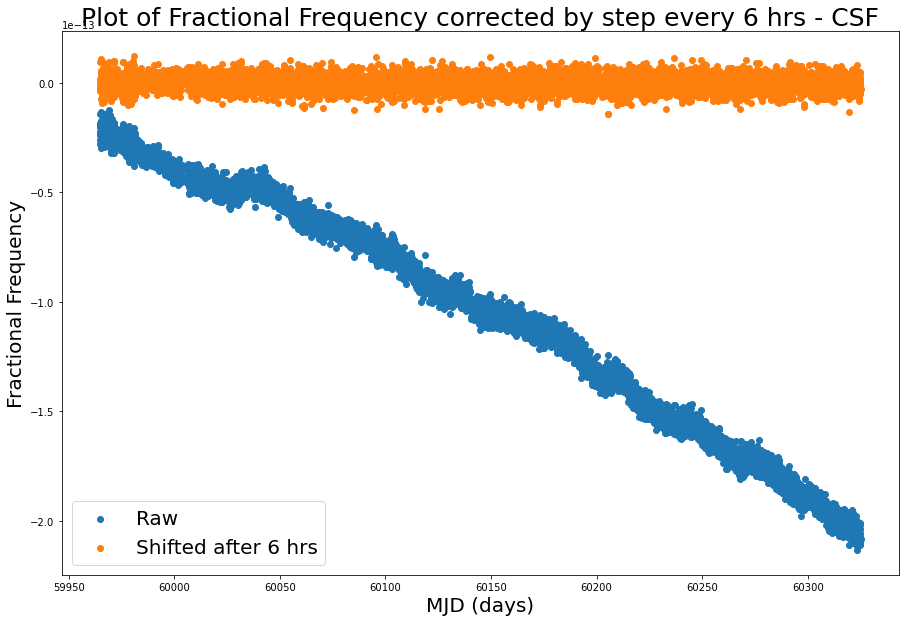

In [273]:
## For 6 hours

(F0_year_CSF_array6,steps6) = (CSF_Correction(np.arange(0,8525,6),6))
plot_steer(6,F0_year_CSF_array6)

(<matplotlib.collections.PathCollection at 0x7fbe0d3d7220>,
 <matplotlib.collections.PathCollection at 0x7fbe0d3d7640>)

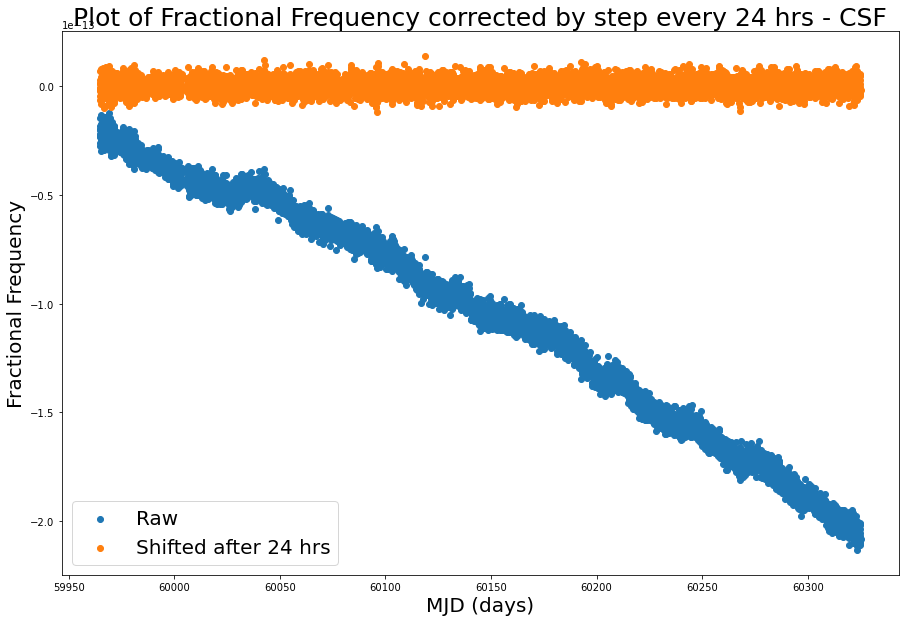

In [274]:
## For 24 hours

(F0_year_CSF_array24,steps24) = (CSF_Correction(np.arange(0,8520,24),24))
plot_steer(24,F0_year_CSF_array24)

(<matplotlib.collections.PathCollection at 0x7fbe0d8ca2e0>,
 <matplotlib.collections.PathCollection at 0x7fbe0dc481c0>)

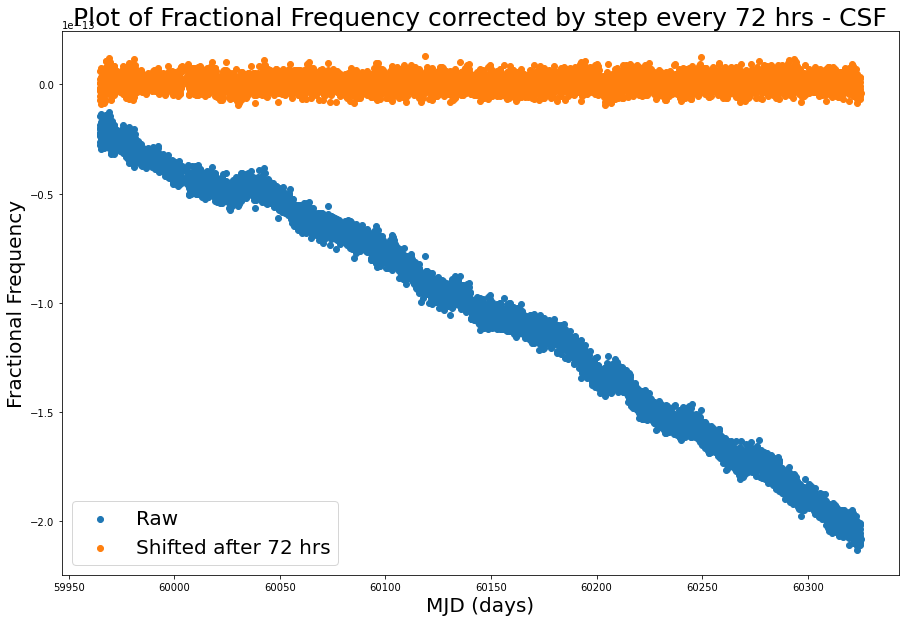

In [275]:
## For 72 hours

(F0_year_CSF_array72,steps72) = (CSF_Correction(np.arange(0,8480,72),72))
plot_steer(72,F0_year_CSF_array72)

(<matplotlib.collections.PathCollection at 0x7fbe0f0cc5e0>,
 <matplotlib.collections.PathCollection at 0x7fbe0f0c2d30>)

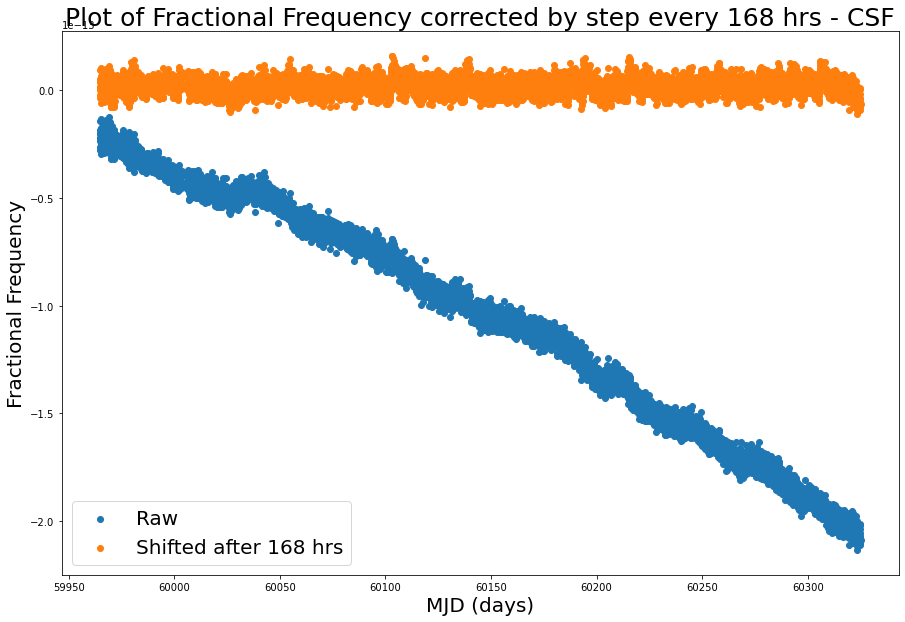

In [276]:
## For 1 week

(F0_year_CSF_array_week,stepsweek) = (CSF_Correction(np.arange(0,8400,168),168))
plot_steer(168,F0_year_CSF_array_week)

(<matplotlib.collections.PathCollection at 0x7fbe0d5b7ca0>,
 <matplotlib.collections.PathCollection at 0x7fbe0d5b7fd0>)

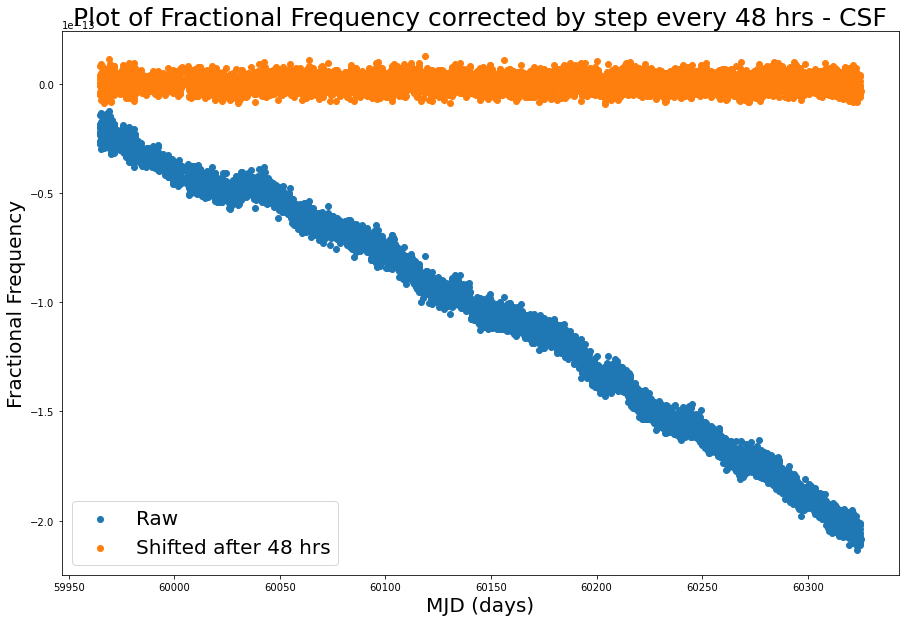

In [277]:
## For 48 hrs

(F0_year_CSF_array_48hrs,steps48) = (CSF_Correction(np.arange(0,8490,48),48))
plot_steer(48,F0_year_CSF_array_48hrs)

## 2.1 - Calculate and Plot Allan Deviations

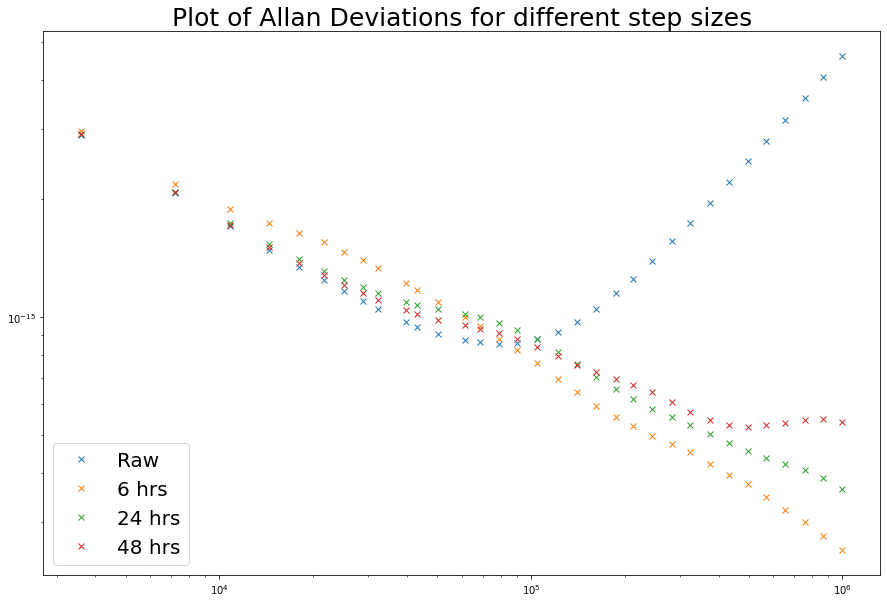

In [278]:
plt.figure(figsize=(15,10))

(t1, ad1, ade1, adn1) = at.oadev(np.array(Generated_data['Generated FF']),1/3600, data_type="freq",taus=np.logspace(0,6,100))
plt.loglog(t1,ad1,'x',label='Raw')

AD6_yr = Allan_Dev(F0_year_CSF_array6,1/3600,np.logspace(0,6,100),6)
AD24_yr = Allan_Dev(F0_year_CSF_array24,1/3600,np.logspace(0,6,100),24)
#AD72_yr = Allan_Dev(F0_year_CSF_array72,1/3600,np.logspace(0,6,100),72)
#AD168_yr = Allan_Dev(F0_year_CSF_array_week,1/3600,np.logspace(0,6,100),168)
AD48_yr = Allan_Dev(F0_year_CSF_array_48hrs,1/3600,np.logspace(0,6,100),48)
#AD_th = Allan_Dev(steered_threshold,1/3600,np.logspace(0,6,100),'Threshold')

plt.title('Plot of Allan Deviations for different step sizes',fontsize=25)
plt.legend(fontsize=20)

# Section 3 - Threshold Steer

In [279]:
## Threshold steer for step size 6 hours

steered_threshold=Threshold_steer(1e-14,np.arange(0,8525,1),6)

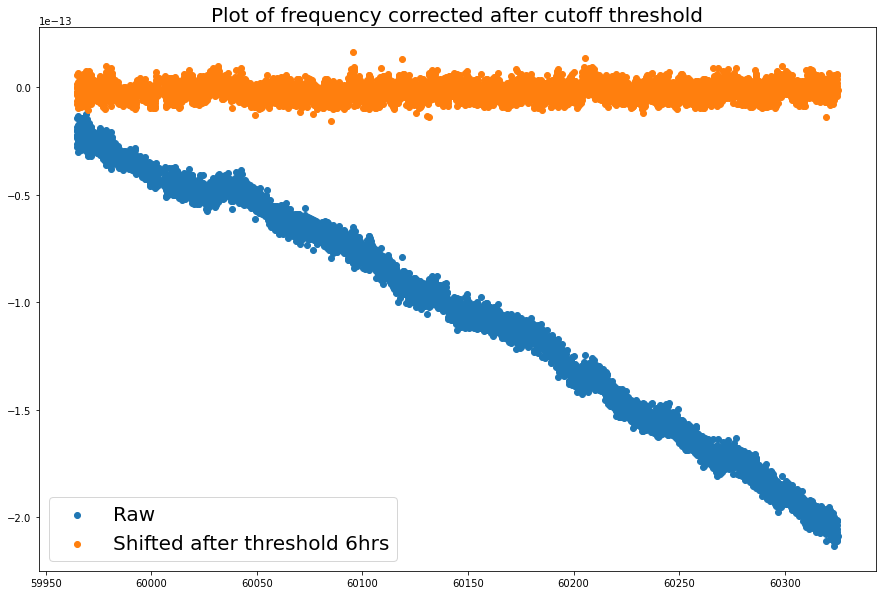

In [280]:
plt.figure(figsize=(15,10))

plt.scatter(Generated_data['Time'], Generated_data['Generated FF'],label='Raw')
plt.scatter(Generated_data['Time'],steered_threshold,label='Shifted after threshold 6hrs')

plt.title('Plot of frequency corrected after cutoff threshold',fontsize=20)
plt.legend(fontsize=20)

In [281]:
## Threshold steer for step size 24 hours

steered_threshold24=Threshold_steer(1e-14,np.arange(0,8500,1),24)

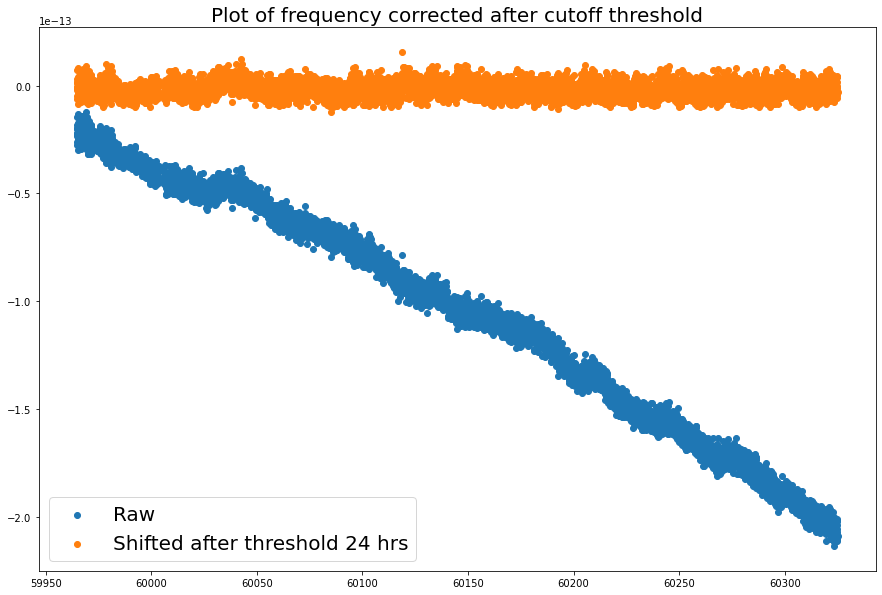

In [282]:
plt.figure(figsize=(15,10))

plt.scatter(Generated_data['Time'], Generated_data['Generated FF'],label='Raw')
plt.scatter(Generated_data['Time'],steered_threshold24,label='Shifted after threshold 24 hrs')

plt.title('Plot of frequency corrected after cutoff threshold',fontsize=20)
plt.legend(fontsize=20)

In [283]:
## Threshold steer for step size 48 hours

steered_threshold48=Threshold_steer(1e-14,np.arange(0,8480,1),48)

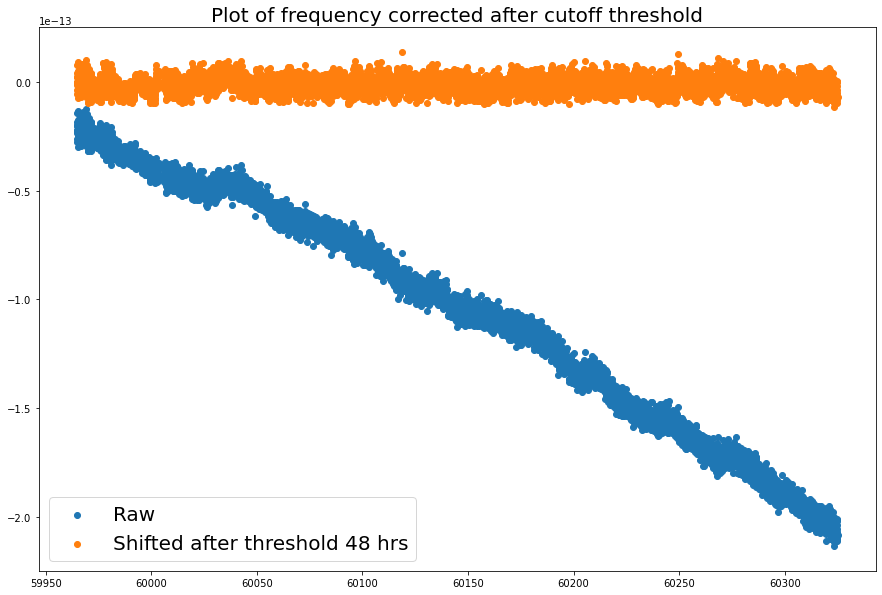

In [284]:
plt.figure(figsize=(15,10))

plt.scatter(Generated_data['Time'], Generated_data['Generated FF'],label='Raw')
plt.scatter(Generated_data['Time'],steered_threshold48,label='Shifted after threshold 48 hrs')

plt.title('Plot of frequency corrected after cutoff threshold',fontsize=20)
plt.legend(fontsize=20)

## 3.1 Calculate and Plot Allan Deviation


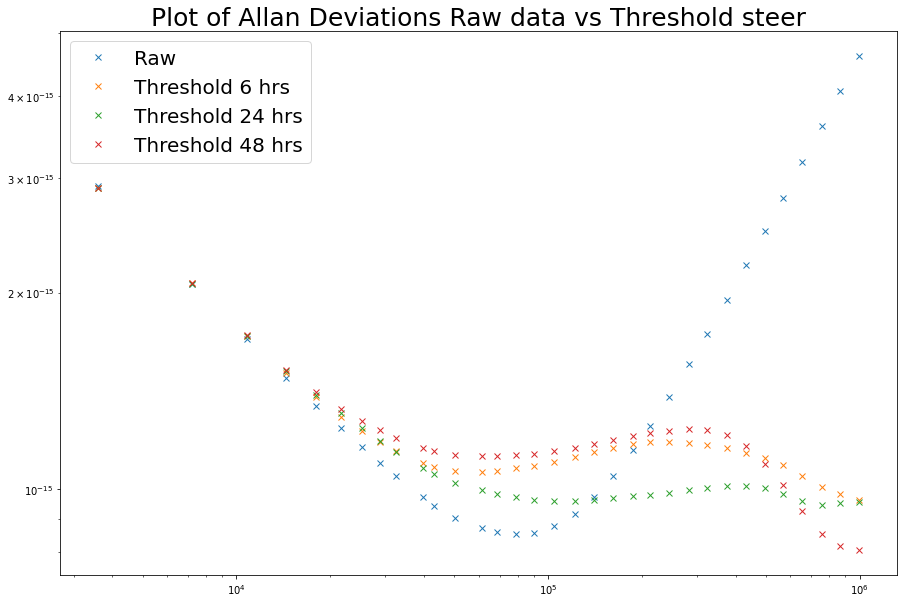

In [285]:
plt.figure(figsize=(15,10))

(t4, ad4, ade4, adn4) = at.oadev(np.array(Generated_data['Generated FF']),1/3600, data_type="freq",taus=np.logspace(0,6,100))
plt.loglog(t4,ad4,'x',label='Raw')

AD_th = Allan_Dev(steered_threshold,1/3600,np.logspace(0,6,100),'Threshold 6')
AD_th24 = Allan_Dev(steered_threshold24,1/3600,np.logspace(0,6,100),'Threshold 24')
AD_th48 = Allan_Dev(steered_threshold48,1/3600,np.logspace(0,6,100),'Threshold 48')

plt.title('Plot of Allan Deviations Raw data vs Threshold steer',fontsize=25)
plt.legend(fontsize=20)

# Section 4 - Smooth Steer

(<matplotlib.collections.PathCollection at 0x7fbe0d0405b0>,
 <matplotlib.collections.PathCollection at 0x7fbe0d0409d0>)

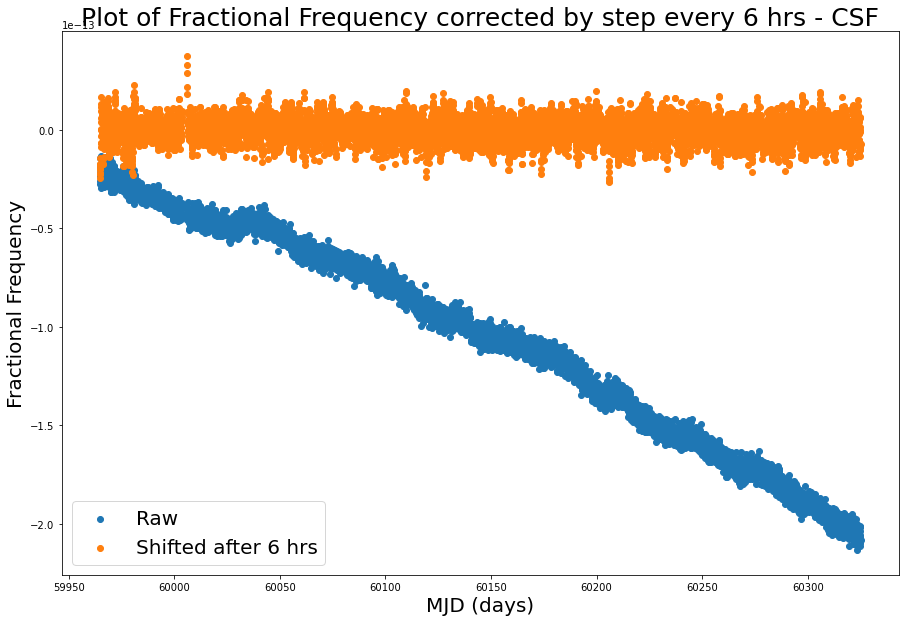

In [286]:
## Smooth steer every 6 hours

smooth_steer_full6 = smooth_steer_CSF(np.arange(0,8525,6),6,.25, np.array(Generated_data['Generated FF']))
plot_steer(6,smooth_steer_full6)

(<matplotlib.collections.PathCollection at 0x7fbe0ce60700>,
 <matplotlib.collections.PathCollection at 0x7fbe0ce60b20>)

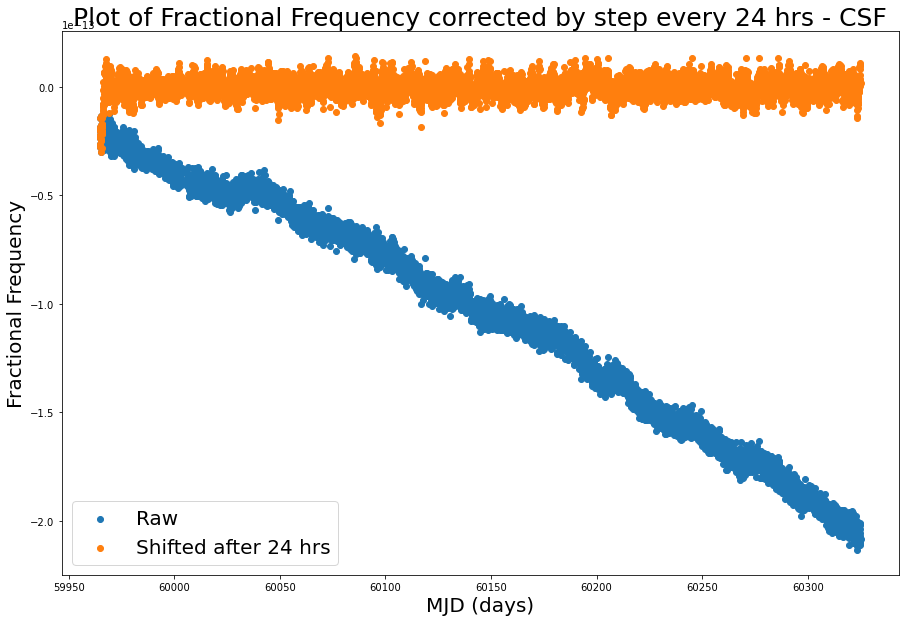

In [287]:
## Smooth steer every 24 hours

smooth_steer_full24 = smooth_steer_CSF(np.arange(0,8510,24),24,1, np.array(Generated_data['Generated FF']))
plot_steer(24,smooth_steer_full24)

(<matplotlib.collections.PathCollection at 0x7fbe0cd927f0>,
 <matplotlib.collections.PathCollection at 0x7fbe0cd92c10>)

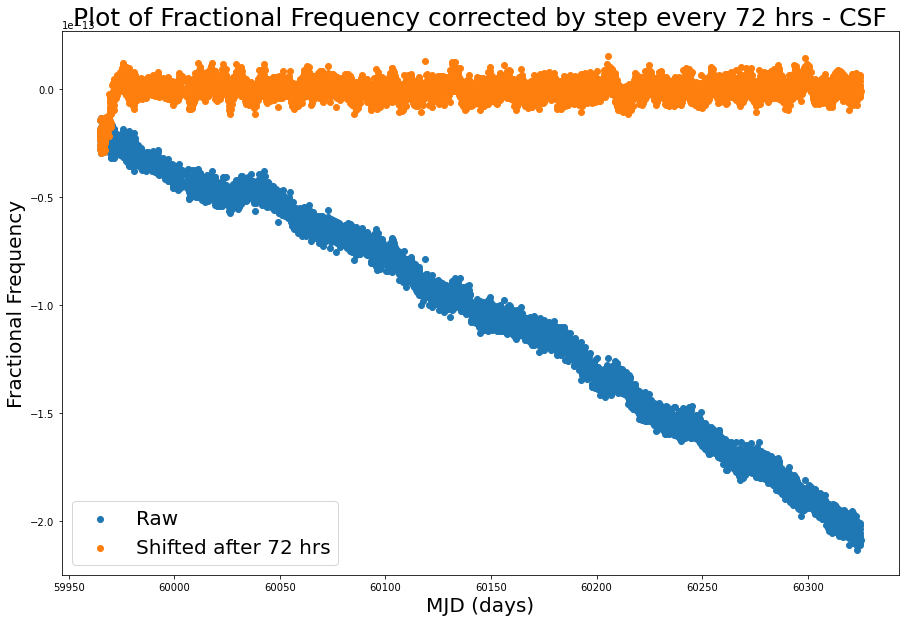

In [288]:
## Smooth steer every 72 hours

smooth_steer_full72 = smooth_steer_CSF(np.arange(0,8480,72),72,3, np.array(Generated_data['Generated FF']))
plot_steer(72,smooth_steer_full72)

(<matplotlib.collections.PathCollection at 0x7fbe0ce037f0>,
 <matplotlib.collections.PathCollection at 0x7fbe0ce03c10>)

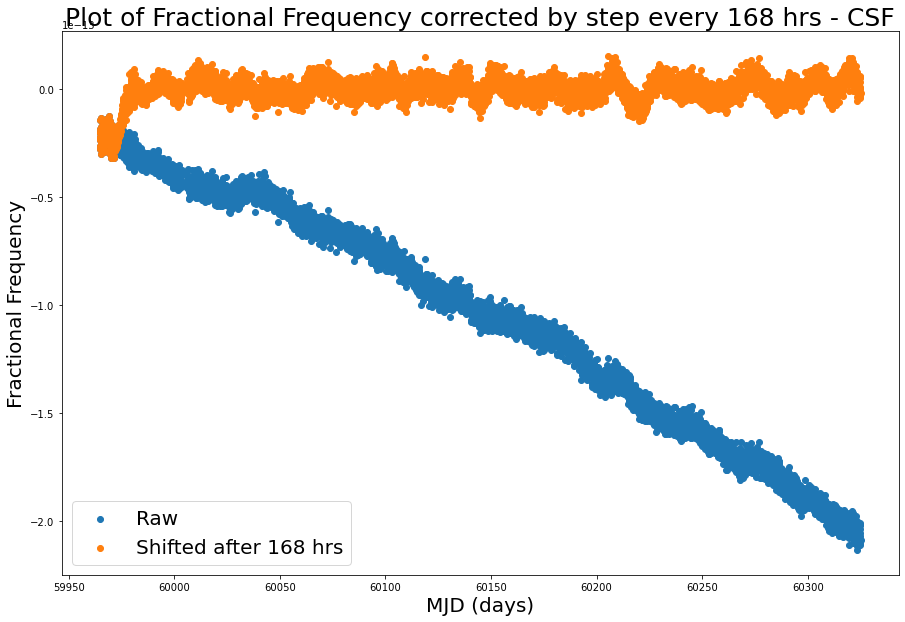

In [289]:
## Smooth steer every week

smooth_steer_fullweek = smooth_steer_CSF(np.arange(0,8400,168),168,7, np.array(Generated_data['Generated FF']))
plot_steer(168,smooth_steer_fullweek)

(<matplotlib.collections.PathCollection at 0x7fbe0cdc97f0>,
 <matplotlib.collections.PathCollection at 0x7fbe0cdc9c10>)

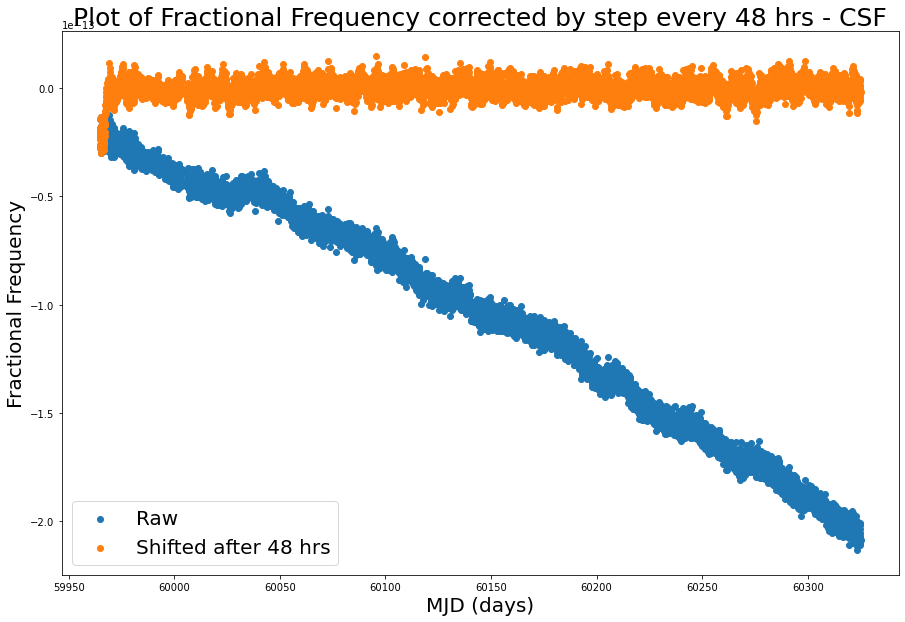

In [290]:
## Smooth steer every 48 hrs

smooth_steer_full48 = smooth_steer_CSF(np.arange(0,8480,48),48,2, np.array(Generated_data['Generated FF']))
plot_steer(48,smooth_steer_full48)

## 4.1 Calculate and Plot Allan Deviations

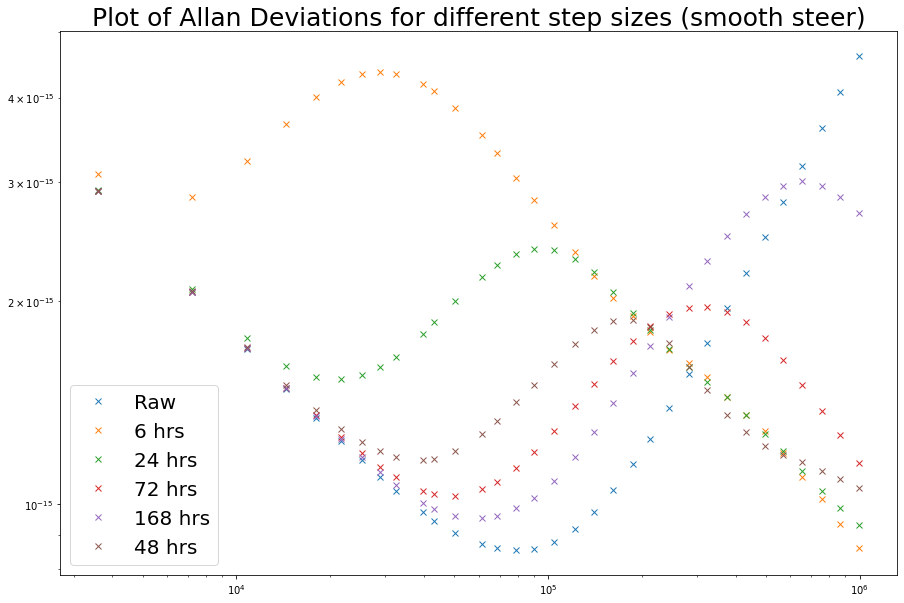

In [291]:
plt.figure(figsize=(15,10))

(t3, ad3, ade3, adn3) = at.oadev(np.array(Generated_data['Generated FF']), rate=1/3600, data_type="freq",taus=np.logspace(0,6,100))
plt.loglog(t3, ad3,'x',label='Raw')

AD6_smooth_1yr = Allan_Dev(smooth_steer_full6,1/3600,np.logspace(0,6,100),6)
AD24_smooth_1yr  = Allan_Dev(smooth_steer_full24,1/3600,np.logspace(0,6,100),24)
AD72_smooth_1yr  = Allan_Dev(smooth_steer_full72,1/3600,np.logspace(0,6,100),72)
AD168_smooth_1yr  = Allan_Dev(smooth_steer_fullweek,1/3600,np.logspace(0,6,100),168)
AD48_smooth_1yr = Allan_Dev(smooth_steer_full48,1/3600,np.logspace(0,6,100),48)

plt.title('Plot of Allan Deviations for different step sizes (smooth steer)',fontsize=25)
plt.legend(fontsize=20)

# Section 5 - Optimise Allan Deviation

In [292]:
AD_differences = []

for i in np.arange(2,170,1):
    
    jump_steer_array, steps = CSF_Correction(np.arange(0,(8531-i),i),i) 
    
    (t5, ad5, ade5, adn5) = at.oadev(np.array(Generated_data['Generated FF']), rate=1/3600, data_type="freq",taus=np.logspace(0,6,100))
    (t6, ad6, ade6, adn6) = at.oadev(jump_steer_array, rate=1/3600, data_type="freq",taus=np.logspace(0,6,100))
    
    difference_array = ad5-ad6
    
    sum_difference_array = np.sum(difference_array)
    
    AD_differences.append(sum_difference_array)

In [293]:
AD_differences[0]

3.137261086111436e-14

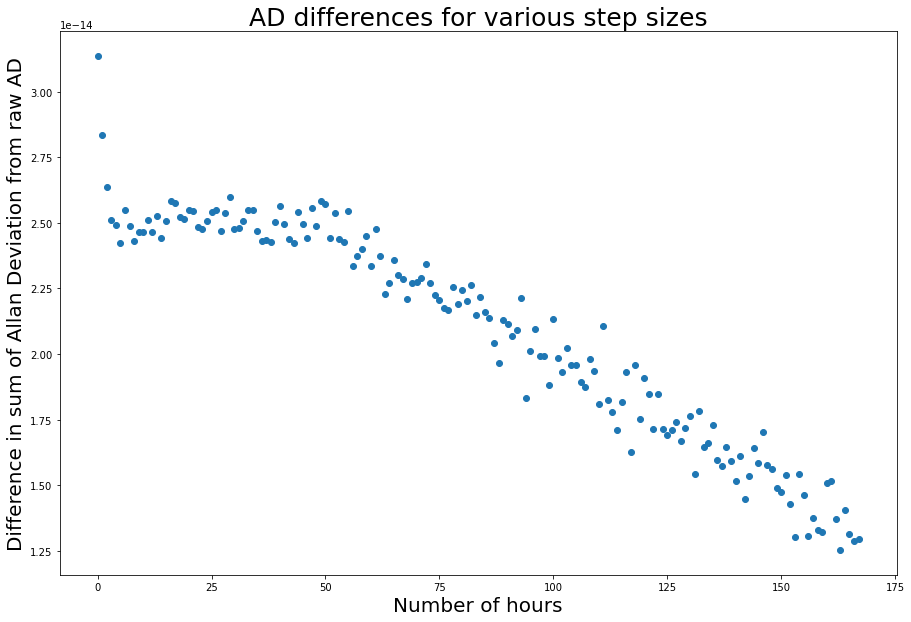

In [294]:
plt.figure(figsize=(15,10))

plt.xlabel('Number of hours',fontsize=20)
plt.ylabel('Difference in sum of Allan Deviation from raw AD',fontsize=20)
plt.title('AD differences for various step sizes',fontsize=25)


plt.plot(AD_differences,'o')

(<matplotlib.collections.PathCollection at 0x7fbe0cc1a6d0>,
 <matplotlib.collections.PathCollection at 0x7fbe0cc1aaf0>)

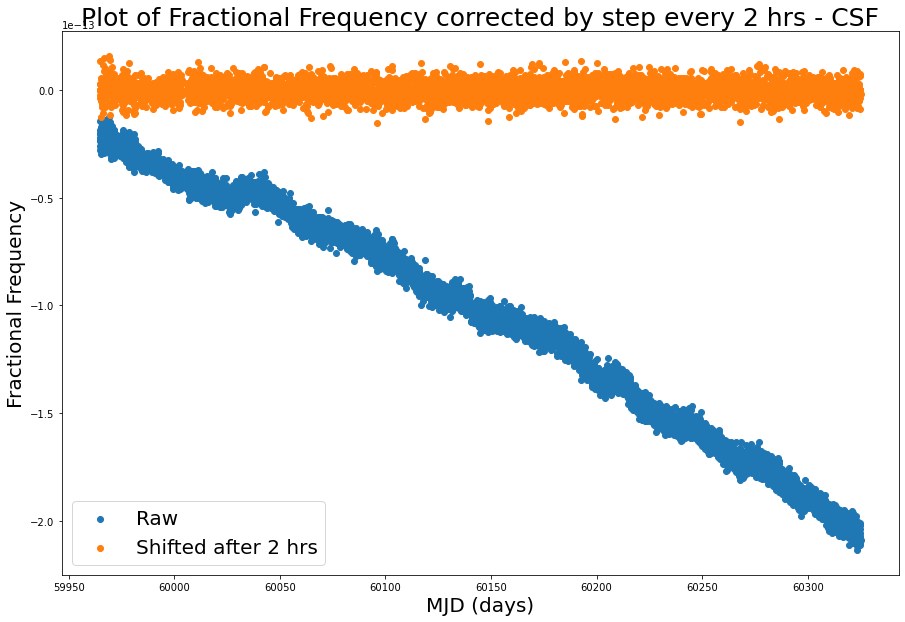

In [295]:
## For 2 hours?

(F0_year_CSF_array_2,steps2) = (CSF_Correction(np.arange(0,8529,2),2))
plot_steer(2,F0_year_CSF_array_2)

(<matplotlib.collections.PathCollection at 0x7fbe0ca347c0>,
 <matplotlib.collections.PathCollection at 0x7fbe0ca34be0>)

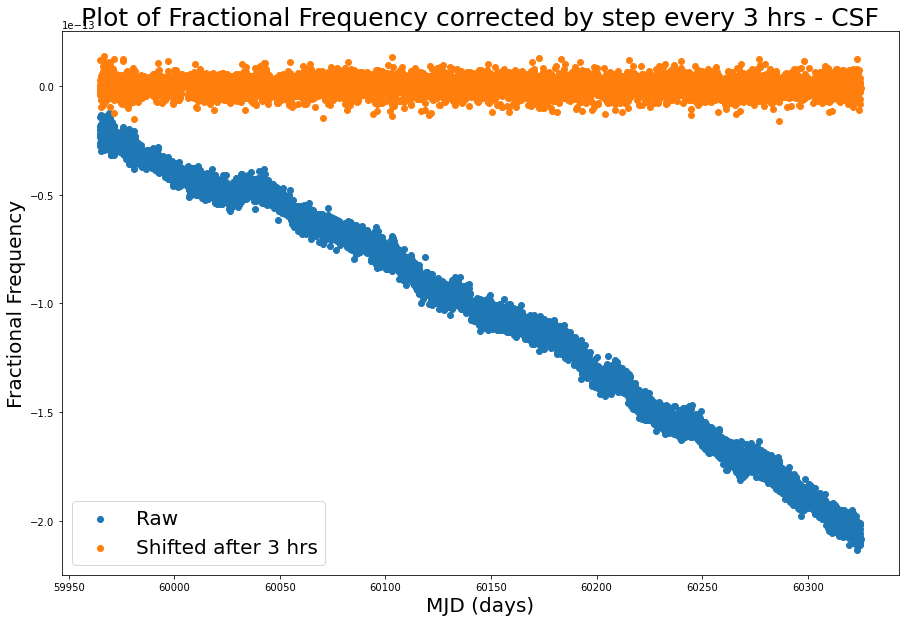

In [296]:
## For 3 hours?

(F0_year_CSF_array_3,steps3) = (CSF_Correction(np.arange(0,8529,3),3))
plot_steer(3,F0_year_CSF_array_3)

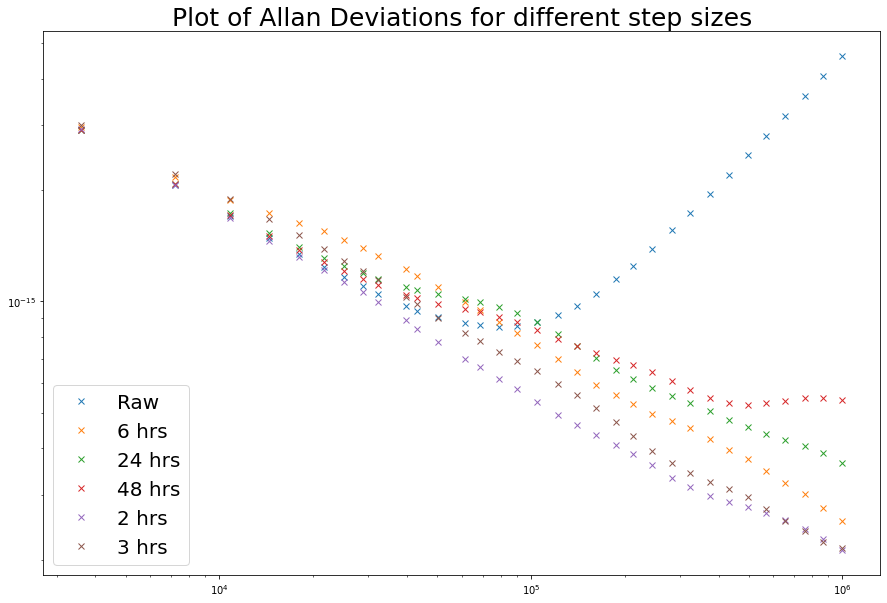

In [297]:
plt.figure(figsize=(15,10))

(t1, ad1, ade1, adn1) = at.oadev(np.array(Generated_data['Generated FF']),1/3600, data_type="freq",taus=np.logspace(0,6,100))
plt.loglog(t1,ad1,'x',label='Raw')

AD6_yr = Allan_Dev(F0_year_CSF_array6,1/3600,np.logspace(0,6,100),6)
AD24_yr = Allan_Dev(F0_year_CSF_array24,1/3600,np.logspace(0,6,100),24)
#AD72_yr = Allan_Dev(F0_year_CSF_array72,1/3600,np.logspace(0,6,100),72)
#AD168_yr = Allan_Dev(F0_year_CSF_array_week,1/3600,np.logspace(0,6,100),168)
AD48_yr = Allan_Dev(F0_year_CSF_array_48hrs,1/3600,np.logspace(0,6,100),48)
AD2_yr = Allan_Dev(F0_year_CSF_array_2,1/3600,np.logspace(0,6,100),2)
AD3_yr = Allan_Dev(F0_year_CSF_array_3,1/3600,np.logspace(0,6,100),3)

plt.title('Plot of Allan Deviations for different step sizes',fontsize=25)
plt.legend(fontsize=20)

In [298]:
(t7, ad7, ade7, adn7) = at.oadev(F0_year_CSF_array_3,1/3600, data_type="freq",taus=np.logspace(0,6,100))

In [299]:
np.sum(ad1-ad7)

2.8367463874793545e-14